In [ ]:
!pip install --upgrade pip
!pip install ipywidgets
!pip install statsmodels

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math

from scipy.stats import norm

import statsmodels.api as sm
import itertools
from ipywidgets import interact, interactive

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 34.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.9/214.9 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 11.1 MB/s eta 0:00:00


# Data

In [ ]:
# Load data
candidate_summ = pd.read_csv("candidate_summary_2018.csv")
dem = pd.read_csv("dem_candidates.csv")
rep = pd.read_csv("rep_candidates.csv", encoding='latin-1')

In [ ]:
# Filter data only to include Senate and House candidates
dem = dem[dem["Office Type"] != "Governor"]
rep = rep[rep["Office Type"] != "Governor"]

In [ ]:
# Filter funding dataset to only include Republican and Democrat candidates
dem_and_rep_fund = candidate_summ[(candidate_summ["Cand_Party_Affiliation"] == "DEM") | 
(candidate_summ["Cand_Party_Affiliation"] == "REP") & (candidate_summ["Cand_Office_St"].isin(rep["State"].unique()))]
dem_and_rep_fund

,Link_Image,Cand_Name,Cand_Id,Cand_Office,Cand_Office_St,Cand_Office_Dist,Cand_Party_Affiliation,Cand_Incumbent_Challenger_Open_Seat,Total_Receipt,Total_Disbursement,...,Individual_Refund,Party_Committee_Refund,Other_Committee_Refund,Total_Contribution_Refund,Other_Disbursements,Net_Contribution,Net_Operating_Expenditure,Cash_On_Hand_BOP,Debt_Owe_To_Committee,Coverage_Start_Date
1,https://www.fec.gov/data/candidate/S6OH00288/?...,"ECKHART, DON ELIJAH",S6OH00288,S,OH,0.0,REP,CHALLENGER,0.00,0.00,...,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,NaN
3,https://www.fec.gov/data/candidate/H6NJ13191/?...,"SIRES, ALBIO",H6NJ13191,H,NJ,8.0,DEM,INCUMBENT,460108.57,596546.56,...,0.00,0.0,500.0,500.00,98504.05,459357.05,437542.51,290287.08,0.00,01/01/2017
5,https://www.fec.gov/data/candidate/H4CA42078/?...,"ROBERTS, BOYD LACHLAN",H4CA42078,H,CA,48.0,DEM,CHALLENGER,0.00,0.00,...,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,NaN
6,https://www.fec.gov/data/candidate/H8NJ07207/?...,"BROWN, LINDSAY CHRISTINE MRS.",H8NJ07207,H,NJ,7.0,REP,CHALLENGER,4365.06,7357.50,...,0.00,0.0,0.0,0.00,0.00,4365.06,7357.50,0.00,0.00,02/18/2017
7,https://www.fec.gov/data/candidate/H8IL18092/?...,"DETERS, BRIAN",H8IL18092,H,IL,18.0,DEM,CHALLENGER,20583.09,19770.32,...,100.00,0.0,0.0,100.00,0.00,20483.09,19670.32,0.00,0.00,09/03/2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3788,https://www.fec.gov/data/candidate/H6OR04203/?...,"PERKINS, JO RAE",H6OR04203,H,OR,4.0,REP,CHALLENGER,14623.38,14464.30,...,0.00,0.0,0.0,0.00,144.10,8735.04,14225.20,21.90,0.00,01/01/2017
3789,https://www.fec.gov/data/candidate/H6NV01232/?...,"D'SILVA, REUBEN",H6NV01232,H,NV,1.0,DEM,CHALLENGER,90878.09,82884.55,...,682.85,0.0,0.0,682.85,552.01,89812.39,80898.68,956.20,552.01,01/01/2017
3790,https://www.fec.gov/data/candidate/H8PA18181/?...,"LAMB, CONOR",H8PA18181,H,PA,17.0,DEM,INCUMBENT,9145124.54,8898568.71,...,104688.54,0.0,5500.0,110188.54,44886.99,8768697.23,8718422.04,0.00,0.00,10/01/2017
3791,https://www.fec.gov/data/candidate/H6PA07113/?...,"LI, LINDY",H6PA07113,H,PA,5.0,DEM,CHALLENGER,168138.00,306024.19,...,0.00,0.0,0.0,0.00,2066.00,168138.00,303958.19,158885.10,0.00,01/01/2017


In [ ]:
# merge republican and democrat datasets with funding
dem_and_rep_fund[["first",'last']] = dem_and_rep_fund["Cand_Name"].str.lower().str.split(",").apply(pd.Series)[[1,0]]
dem[["first",'last']] = dem["Candidate"].str.lower().str.split(' ', n=1).apply(pd.Series)[[0,1]]
rep[["first",'last']] = rep["Candidate"].str.lower().str.split(' ', n=1).apply(pd.Series)[[0,1]]

dem_merged = pd.merge(dem_and_rep_fund[(dem_and_rep_fund["Cand_Party_Affiliation"] == "DEM")], 
         dem, left_on= ["last","Cand_Office_St"], right_on= ["last","State"])
rep_merged = pd.merge(dem_and_rep_fund[(dem_and_rep_fund["Cand_Party_Affiliation"] == "REP")], 
         rep, left_on= ["last","Cand_Office_St"], right_on= ["last","State"]).rename(columns={'Rep Party Support?':'Party Support?'})

all_merged = pd.concat([rep_merged, dem_merged], ignore_index=True)
swing = ['NH', 'MN', 'MI', 'NV', 'PA', 'WI', 'AZ', 'GA', 'NC', 'FL', 'TX']
all_merged['Swing?'] = all_merged['State'].isin(swing).replace({True: 'Yes', False: 'No'})
all_merged

/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Link_Image,Cand_Name,Cand_Id,Cand_Office,Cand_Office_St,Cand_Office_Dist,Cand_Party_Affiliation,Cand_Incumbent_Challenger_Open_Seat,Total_Receipt,Total_Disbursement,...,Biden Endorsed?,Warren Endorsed?,Sanders Endorsed?,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,VoteVets Endorsed?,Swing?
0,https://www.fec.gov/data/candidate/S6OH00288/?...,"ECKHART, DON ELIJAH",S6OH00288,S,OH,0.0,REP,CHALLENGER,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
1,https://www.fec.gov/data/candidate/S8CT00113/?...,"RAPINI, DOMINIC",S8CT00113,S,CT,0.0,REP,CHALLENGER,198123.57,168307.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2,https://www.fec.gov/data/candidate/H6RI02284/?...,"CAIOZZO, SALVATORE",H6RI02284,H,RI,2.0,REP,CHALLENGER,4960.00,3525.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3,https://www.fec.gov/data/candidate/S8PA00239/?...,"SACCONE, RICK",S8PA00239,S,PA,0.0,REP,CHALLENGER,51207.00,73263.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
4,https://www.fec.gov/data/candidate/H8PA18231/?...,"SACCONE, RICK",H8PA18231,H,PA,14.0,REP,OPEN,2040980.87,2011655.16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1325,https://www.fec.gov/data/candidate/H8TX32098/?...,"ALLRED, COLIN",H8TX32098,H,TX,32.0,DEM,CHALLENGER,5972679.56,5869234.53,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1326,https://www.fec.gov/data/candidate/H8NJ03206/?...,"KIM, ANDY",H8NJ03206,H,NJ,3.0,DEM,CHALLENGER,6439534.88,6375721.12,...,Yes,NaN,NaN,NaN,NaN,Yes,NaN,Yes,NaN,No
1327,https://www.fec.gov/data/candidate/H8NY27176/?...,"MCMURRAY, NATHAN DOUGLAS",H8NY27176,H,NY,27.0,DEM,OPEN,1387653.64,1364110.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,No
1328,https://www.fec.gov/data/candidate/H8MD01177/?...,"GALBRAITH, ALLISON MS.",H8MD01177,H,MD,1.0,DEM,CHALLENGER,110517.66,110197.68,...,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,No,No


## EDA: Multiple Hypothesis Testing

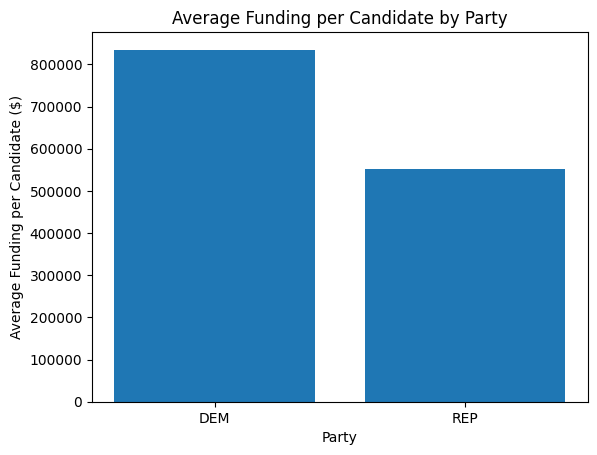

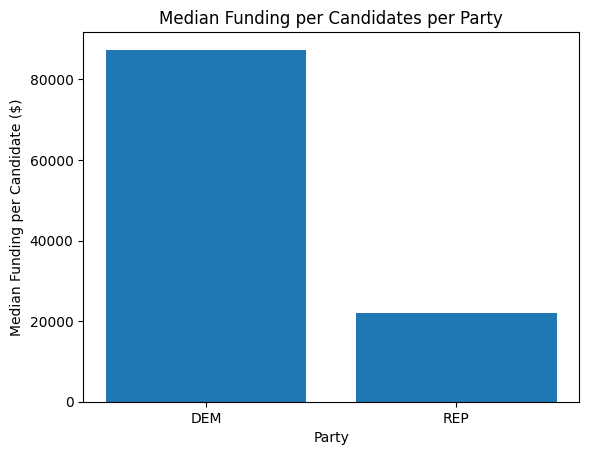

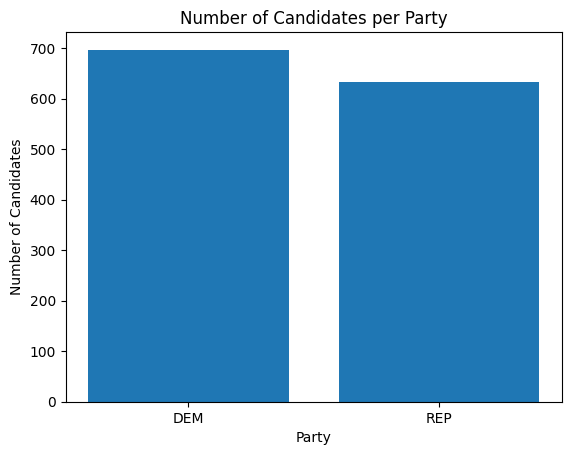

In [ ]:
# EDA for candidate party
per_party = all_merged.groupby('Cand_Party_Affiliation')['Net_Contribution'].mean().reset_index()

plt.bar(per_party['Cand_Party_Affiliation'], per_party['Net_Contribution'])
plt.ylabel('Average Funding per Candidate ($)')
plt.xlabel('Party')
plt.title('Average Funding per Candidate by Party')
plt.show()

per_party_median = all_merged.groupby('Cand_Party_Affiliation')['Net_Contribution'].median().reset_index()

plt.bar(per_party_median['Cand_Party_Affiliation'], per_party_median['Net_Contribution'])
plt.ylabel('Median Funding per Candidate ($)')
plt.xlabel('Party')
plt.title('Median Funding per Candidates per Party')
plt.show()

per_party_count = all_merged.groupby('Cand_Party_Affiliation')['Net_Contribution'].count().reset_index()

plt.bar(per_party_count['Cand_Party_Affiliation'], per_party_count['Net_Contribution'])
plt.ylabel('Number of Candidates')
plt.xlabel('Party')
plt.title('Number of Candidates per Party')
plt.show()

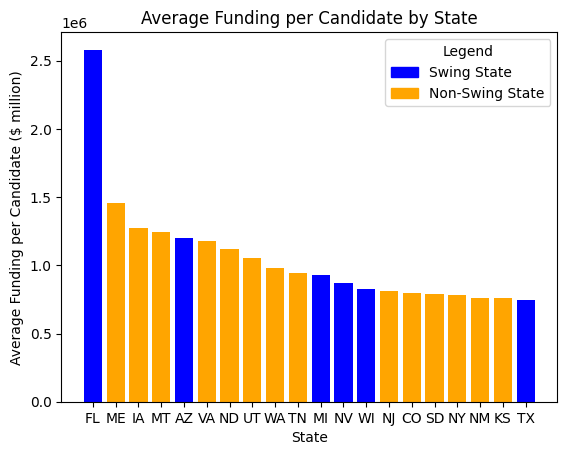

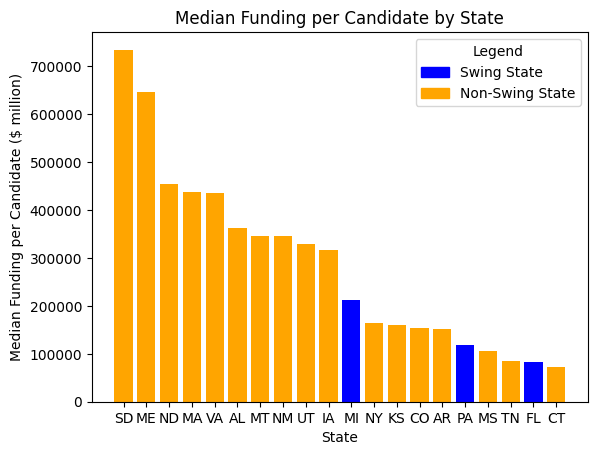

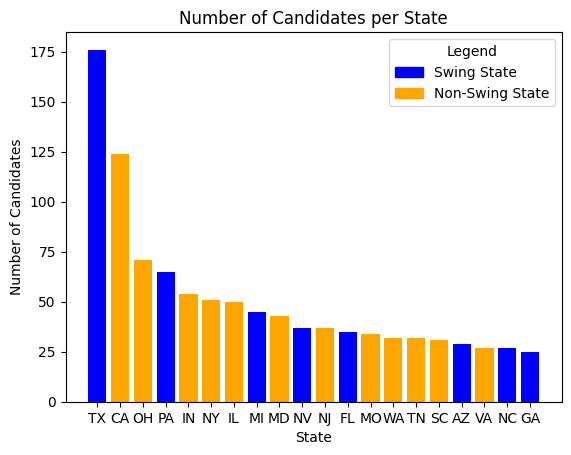

In [ ]:
# EDA for candidate state
per_state = all_merged.groupby('Cand_Office_St')['Net_Contribution'].mean().reset_index().sort_values(by='Net_Contribution', ascending = False).head(20)

swing_states = ['NH', 'MN', 'MI', 'NV', 'PA', 'WI', 'AZ', 'GA', 'NC', 'FL', 'TX']


colors = ['blue' if state in swing_states else 'orange' for state in per_state['Cand_Office_St']]

plt.bar(per_state['Cand_Office_St'], per_state['Net_Contribution'], color=colors)
plt.ylabel('Average Funding per Candidate ($ million)')
plt.xlabel('State')
plt.title('Average Funding per Candidate by State')
legend_labels = {'Swing State': 'blue', 'Non-Swing State': 'orange'}
legend_handles = [plt.Rectangle((0,0),1,1, color=color, label=label) for label, color in legend_labels.items()]
plt.legend(handles=legend_handles, title='Legend')
plt.show()

per_state_median = all_merged.groupby('Cand_Office_St')['Net_Contribution'].median().reset_index().sort_values(by='Net_Contribution', ascending = False).head(20)

colors = ['blue' if state in swing_states else 'orange' for state in per_state_median['Cand_Office_St']]

plt.bar(per_state_median['Cand_Office_St'], per_state_median['Net_Contribution'], color=colors)
plt.ylabel('Median Funding per Candidate ($ million)')
plt.xlabel('State')
plt.title('Median Funding per Candidate by State')
legend_labels = {'Swing State': 'blue', 'Non-Swing State': 'orange'}
legend_handles = [plt.Rectangle((0,0),1,1, color=color, label=label) for label, color in legend_labels.items()]
plt.legend(handles=legend_handles, title='Legend')
plt.show()


per_state_count = all_merged.groupby('Cand_Office_St')['Net_Contribution'].count().reset_index().sort_values(by='Net_Contribution', ascending = False).head(20)

colors = ['blue' if state in swing_states else 'orange' for state in per_state_count['Cand_Office_St']]

plt.bar(per_state_count['Cand_Office_St'], per_state_count['Net_Contribution'], color=colors)
plt.ylabel('Number of Candidates')
plt.xlabel('State')
plt.title('Number of Candidates per State')
legend_labels = {'Swing State': 'blue', 'Non-Swing State': 'orange'}
legend_handles = [plt.Rectangle((0,0),1,1, color=color, label=label) for label, color in legend_labels.items()]
plt.legend(handles=legend_handles, title='Legend')
plt.show()


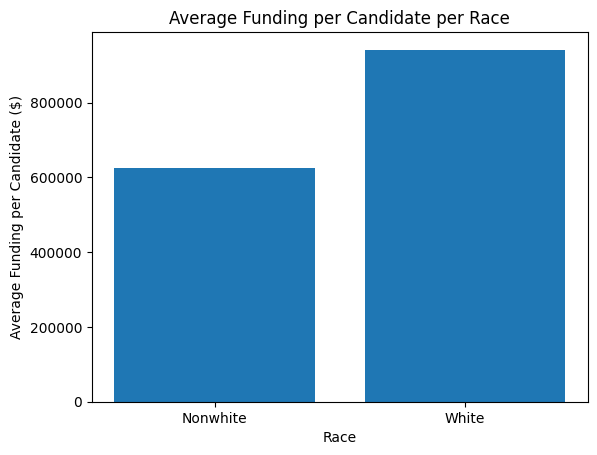

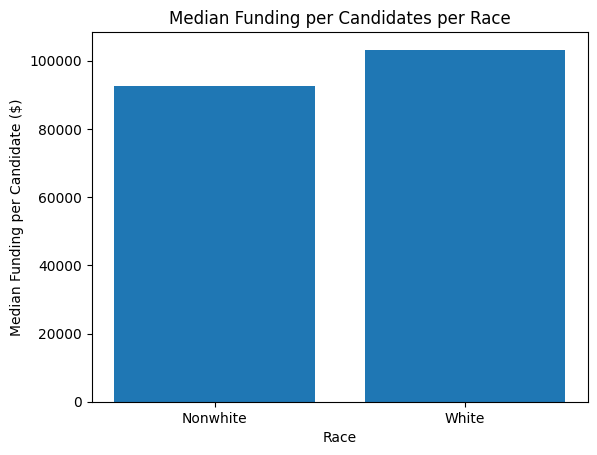

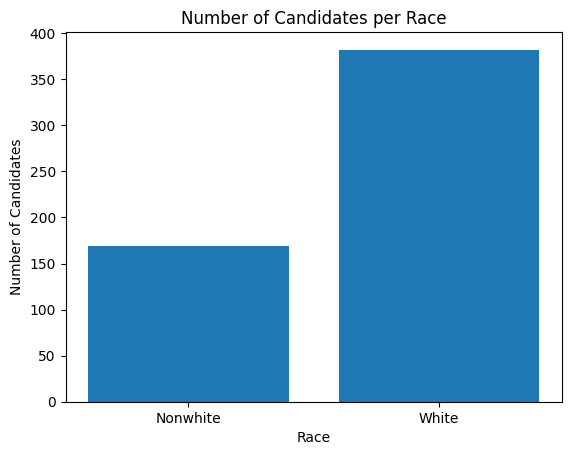

In [ ]:
# EDA for candidate race
per_race = all_merged.groupby('Race')['Net_Contribution'].mean().reset_index()

plt.bar(per_race['Race'], per_race['Net_Contribution'])
plt.ylabel('Average Funding per Candidate ($)')
plt.xlabel('Race')
plt.title('Average Funding per Candidate per Race')
plt.show()

per_race_median = all_merged.groupby('Race')['Net_Contribution'].median().reset_index()

plt.bar(per_race_median['Race'], per_race_median['Net_Contribution'])
plt.ylabel('Median Funding per Candidate ($)')
plt.xlabel('Race')
plt.title('Median Funding per Candidates per Race')
plt.show()

per_race_count = all_merged.groupby('Race')['Net_Contribution'].count().reset_index()

plt.bar(per_race_count['Race'], per_race_count['Net_Contribution'])
plt.ylabel('Number of Candidates')
plt.xlabel('Race')
plt.title('Number of Candidates per Race')
plt.show()

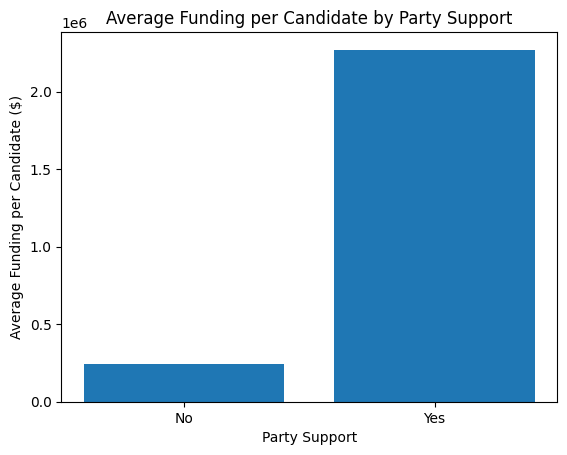

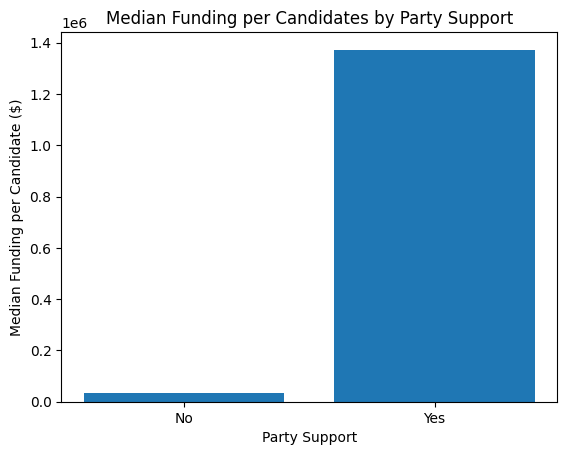

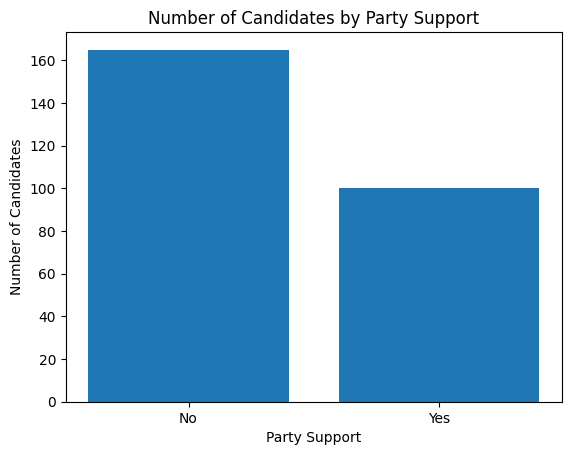

In [ ]:
# EDA for candidate endorsement
per_race = all_merged.groupby('Party Support?')['Net_Contribution'].mean().reset_index()

plt.bar(per_race['Party Support?'], per_race['Net_Contribution'])
plt.ylabel('Average Funding per Candidate ($)')
plt.xlabel('Party Support')
plt.title('Average Funding per Candidate by Party Support')
plt.show()

per_race_median = all_merged.groupby('Party Support?')['Net_Contribution'].median().reset_index()

plt.bar(per_race_median['Party Support?'], per_race_median['Net_Contribution'])
plt.ylabel('Median Funding per Candidate ($)')
plt.xlabel('Party Support')
plt.title('Median Funding per Candidates by Party Support')
plt.show()

per_race_count = all_merged.groupby('Party Support?')['Net_Contribution'].count().reset_index()

plt.bar(per_race_count['Party Support?'], per_race_count['Net_Contribution'])
plt.ylabel('Number of Candidates')
plt.xlabel('Party Support')
plt.title('Number of Candidates by Party Support')
plt.show()

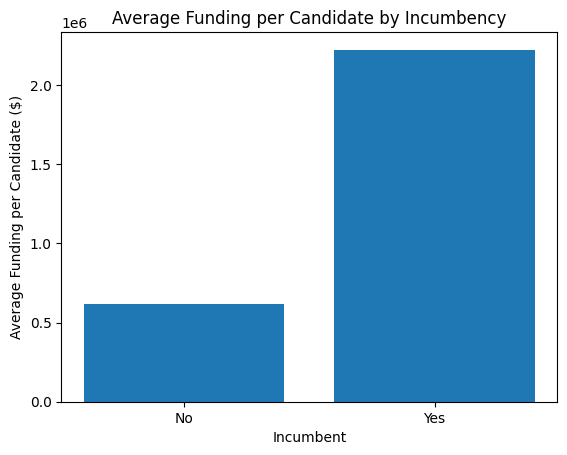

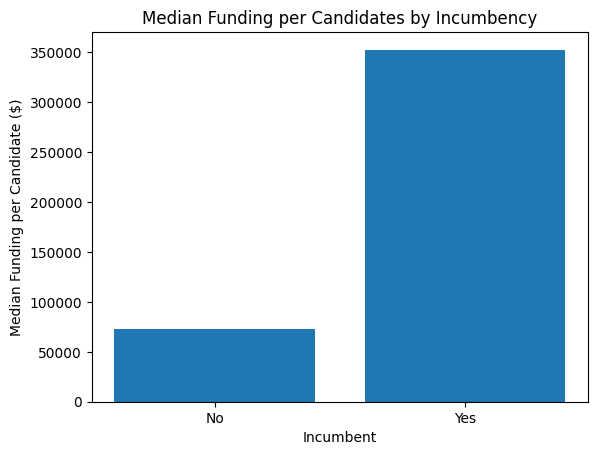

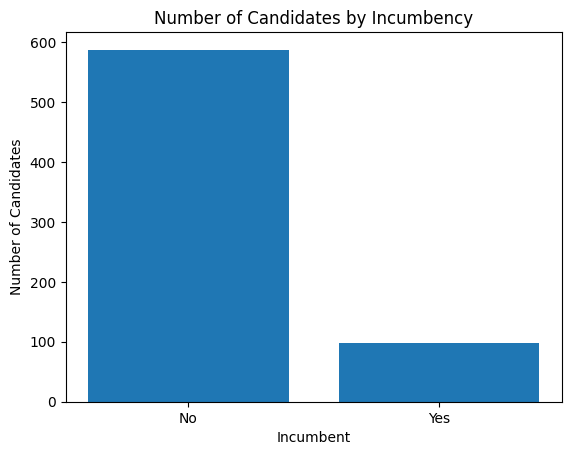

In [ ]:
# EDA for candidate incumbency

per_race = all_merged.groupby('Elected Official?')['Net_Contribution'].mean().reset_index()

plt.bar(per_race['Elected Official?'], per_race['Net_Contribution'])
plt.ylabel('Average Funding per Candidate ($)')
plt.xlabel('Incumbent')
plt.title('Average Funding per Candidate by Incumbency')
plt.show()

per_race_median = all_merged.groupby('Elected Official?')['Net_Contribution'].median().reset_index()

plt.bar(per_race_median['Elected Official?'], per_race_median['Net_Contribution'])
plt.ylabel('Median Funding per Candidate ($)')
plt.xlabel('Incumbent')
plt.title('Median Funding per Candidates by Incumbency')
plt.show()

per_race_count = all_merged.groupby('Elected Official?')['Net_Contribution'].count().reset_index()

plt.bar(per_race_count['Elected Official?'], per_race_count['Net_Contribution'])
plt.ylabel('Number of Candidates')
plt.xlabel('Incumbent')
plt.title('Number of Candidates by Incumbency')
plt.show()

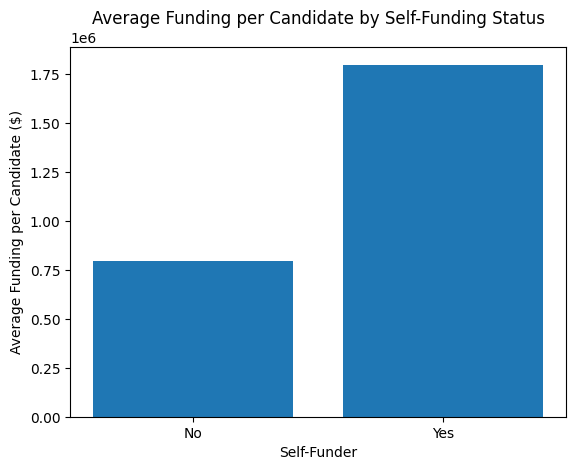

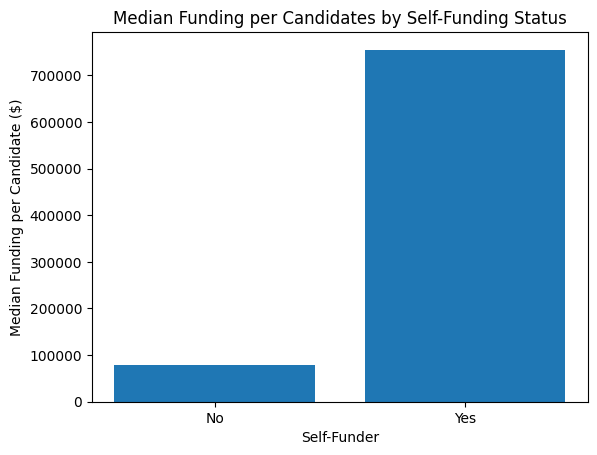

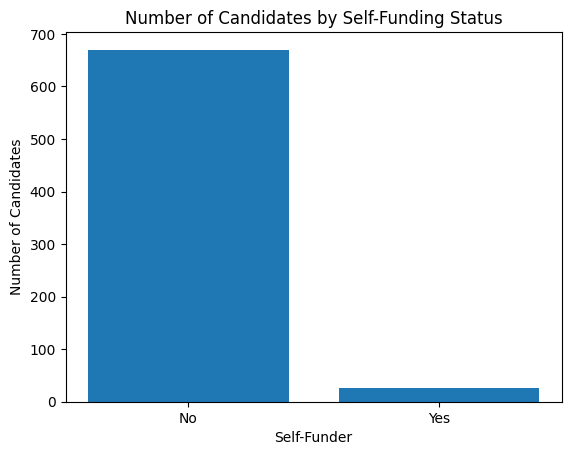

In [ ]:
# EDA for candidate self-funding status
per_race = all_merged.groupby('Self-Funder?')['Net_Contribution'].mean().reset_index()

plt.bar(per_race['Self-Funder?'], per_race['Net_Contribution'])
plt.ylabel('Average Funding per Candidate ($)')
plt.xlabel('Self-Funder')
plt.title('Average Funding per Candidate by Self-Funding Status')
plt.show()

per_race_median = all_merged.groupby('Self-Funder?')['Net_Contribution'].median().reset_index()

plt.bar(per_race_median['Self-Funder?'], per_race_median['Net_Contribution'])
plt.ylabel('Median Funding per Candidate ($)')
plt.xlabel('Self-Funder')
plt.title('Median Funding per Candidates by Self-Funding Status')
plt.show()

per_race_count = all_merged.groupby('Self-Funder?')['Net_Contribution'].count().reset_index()

plt.bar(per_race_count['Self-Funder?'], per_race_count['Net_Contribution'])
plt.ylabel('Number of Candidates')
plt.xlabel('Self-Funder')
plt.title('Number of Candidates by Self-Funding Status')
plt.show()

In [ ]:
# data filtered to include only the variables for the hypothesis tests
all_filtered = all_merged[['Candidate',"State",'Cand_Party_Affiliation', 'Net_Contribution',"Race", "Party Support?",'Self-Funder?', 'Swing?','Elected Official?']]
all_filtered

,Candidate,State,Cand_Party_Affiliation,Net_Contribution,Race,Party Support?,Self-Funder?,Swing?,Elected Official?
0,Don Eckhart,OH,REP,0.00,NaN,NaN,NaN,No,NaN
1,Dominic Rapini,CT,REP,121131.00,NaN,NaN,NaN,No,NaN
2,Salvatore Caiozzo,RI,REP,1860.00,NaN,NaN,NaN,No,NaN
3,Rick Saccone,PA,REP,51207.00,NaN,NaN,NaN,Yes,NaN
4,Rick Saccone,PA,REP,1770173.79,NaN,NaN,NaN,Yes,NaN
...,...,...,...,...,...,...,...,...,...
1325,Colin Allred,TX,DEM,5347252.57,Nonwhite,Yes,No,Yes,No
1326,Andrew Kim,NJ,DEM,5728583.20,Nonwhite,Yes,No,No,No
1327,Nate McMurray,NY,DEM,1354858.98,White,NaN,No,No,Yes
1328,Allison Galbraith,MD,DEM,110167.66,White,NaN,No,No,No


In [ ]:
# Funding outliers, three sd above mean
funding_outliers = all_filtered[all_filtered['Net_Contribution'] > np.mean(all_filtered['Net_Contribution']) + np.std(all_merged['Net_Contribution']) * 3]

print(funding_outliers.to_latex(index=False))

\begin{tabular}{lllrlllll}
\toprule
       Candidate & State & Cand\_Party\_Affiliation &  Net\_Contribution &  Race & Party Support? & Self-Funder? & Swing? & Elected Official? \\
\midrule
      John James &    MI &                    REP &       12229389.45 &   NaN &            NaN &          NaN &    Yes &               NaN \\
Marsha Blackburn &    TN &                    REP &       12249043.31 &   NaN &            NaN &          NaN &     No &               NaN \\
  Martha McSally &    AZ &                    REP &       17907003.18 &   NaN &            NaN &          NaN &    Yes &               NaN \\
      Rick Scott &    FL &                    REP &       82702798.34 &   NaN &            NaN &          NaN &    Yes &               NaN \\
     Jacky Rosen &    NV &                    DEM &       23791657.75 &   NaN &            Yes &           No &    Yes &               Yes \\
   Beto O'Rourke &    TX &                    DEM &       78904203.61 & White &            NaN &    

# Multiple Hypothesis Testing

In [ ]:
# calc pval and plot graph
def diff_in_means(df, hyp_var, funding_var):
    target_series = df.groupby(hyp_var).mean()[funding_var]
    observed_difference = abs(target_series[0] - target_series[1])
    return observed_difference

def avg_difference_in_means(binary_col, numerical_col):
    obs_diff = diff_in_means(all_merged, binary_col, numerical_col)
    
    diff_arr = []
    na = all_merged.dropna(subset=[binary_col])
    for _ in np.arange(1000):
        na['Shuffled Labels'] = na[binary_col].sample(len(na)).values
        shuffled_diff = diff_in_means(na, 'Shuffled Labels', numerical_col)
        diff_arr = np.append(diff_arr, shuffled_diff)
    
    p_val = np.count_nonzero(diff_arr >= obs_diff) / len(diff_arr)


    plt.figure()
    plt.hist(diff_arr)
    plt.axvline(obs_diff, color='red')
    plt.title('Prediction Under the Null')
    plt.xlabel('Difference Between Group Means')
    plt.ylabel('Percent per unit')
    plt.show();
    printStr = "Group: " + binary_col + "| Stat: " + numerical_col + " | Computed P-value: " + (str)(p_val) 
    print(printStr)
    print()

    return p_val

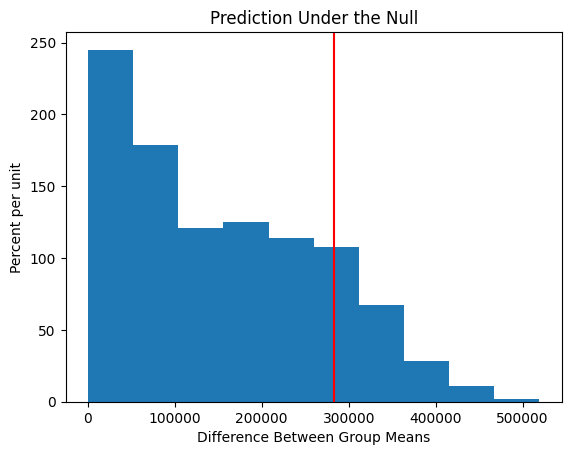

Group: Cand_Party_Affiliation| Stat: Net_Contribution | Computed P-value: 0.161



In [ ]:
# party affiliation pval
diff_in_means(all_merged,'Cand_Party_Affiliation',  'Net_Contribution')
party_pval = avg_difference_in_means('Cand_Party_Affiliation', 'Net_Contribution')

In [ ]:
# calc power
def power_of_test(df, binary_col, numerical_col, num_simulations=10000):
    obs_diff = diff_in_means(df, binary_col, numerical_col)
    
    null_diff_arr = []
    for _ in range(num_simulations):
        df['Shuffled Labels'] = df[binary_col].sample(len(df)).values
        shuffled_diff = diff_in_means(df, 'Shuffled Labels', numerical_col)
        null_diff_arr.append(shuffled_diff)
    
    p_val = np.count_nonzero(null_diff_arr >= obs_diff) / num_simulations

    alt_diff_arr = []
    for _ in range(num_simulations):
        df['Shuffled Labels'] = df[binary_col].sample(len(df)).values
        shuffled_diff2 = diff_in_means(df, 'Shuffled Labels', numerical_col)
        alt_diff_arr.append(shuffled_diff2)

    power = np.count_nonzero(alt_diff_arr >= obs_diff) / num_simulations


    printStr = "Group: " + binary_col + " | Stat: " + numerical_col + " | P-value: " + str(p_val) + " | Power: " + str(power)
    print(printStr)
    print()

    return p_val, power

p_val, power = power_of_test(all_merged, 'Self-Funder?', 'Net_Contribution')


Group: Self-Funder? | Stat: Net_Contribution | P-value: 0.0471 | Power: 0.0451



/tmp/ipykernel_954/362715203.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  na['Shuffled Labels'] = na[binary_col].sample(len(na)).values


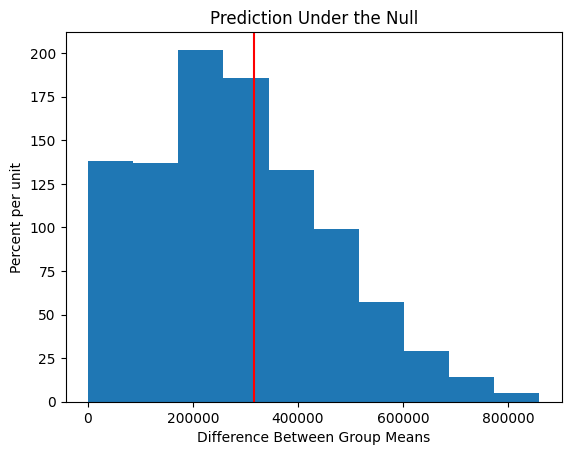

Group: Race| Stat: Net_Contribution | Computed P-value: 0.396



In [ ]:
# race pval
diff_in_means(all_merged,'Race',  'Net_Contribution')
race_pval = avg_difference_in_means('Race', 'Net_Contribution')

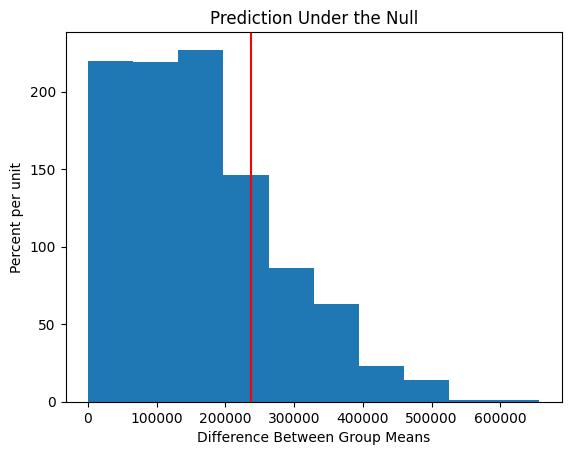

Group: Swing?| Stat: Net_Contribution | Computed P-value: 0.248



In [ ]:
# swing state pval
diff_in_means( all_merged,"Swing?",  'Net_Contribution')
swing_pval = avg_difference_in_means("Swing?", 'Net_Contribution')

/tmp/ipykernel_954/362715203.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  na['Shuffled Labels'] = na[binary_col].sample(len(na)).values


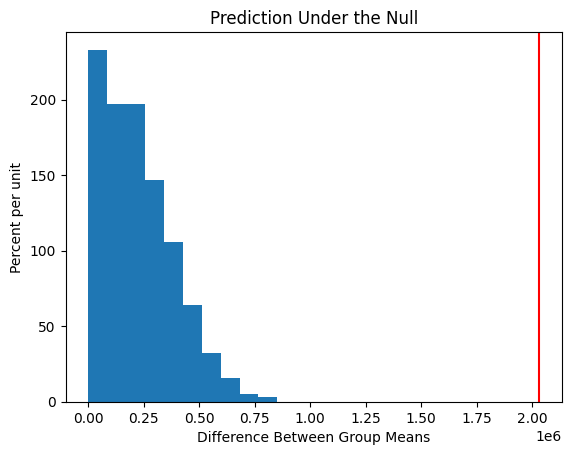

Group: Party Support?| Stat: Net_Contribution | Computed P-value: 0.0



In [ ]:
# party support pval
diff_in_means( all_merged,"Party Support?",  'Net_Contribution')
party_support_pval = avg_difference_in_means("Party Support?", 'Net_Contribution')


/tmp/ipykernel_954/362715203.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  na['Shuffled Labels'] = na[binary_col].sample(len(na)).values


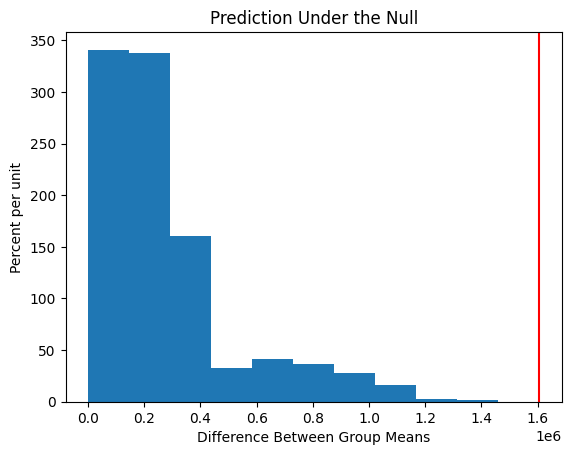

Group: Elected Official?| Stat: Net_Contribution | Computed P-value: 0.0



In [ ]:
# incumbent pval
diff_in_means( all_merged,"Elected Official?",  'Net_Contribution')
incumbent_pval = avg_difference_in_means("Elected Official?", 'Net_Contribution')

/tmp/ipykernel_954/362715203.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  na['Shuffled Labels'] = na[binary_col].sample(len(na)).values


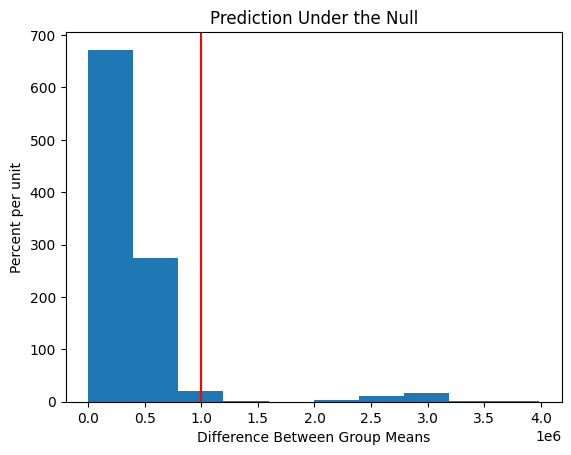

Group: Self-Funder?| Stat: Net_Contribution | Computed P-value: 0.04



In [ ]:
# self-funder pval
diff_in_means( all_merged,"Self-Funder?",  'Net_Contribution')
self_fund_pval = avg_difference_in_means("Self-Funder?", 'Net_Contribution')

In [ ]:
# corrections and df for pvals
p_val_arr = [party_pval, race_pval, swing_pval, party_support_pval, incumbent_pval, self_fund_pval]
p_val_names = ['party_pval', 'race_pval', 'swing_pval', 'party_support_pval', 'incumbent_pval', 'self_fund_pval']
p_val_df = pd.DataFrame(data = [p_val_names,p_val_arr]).T.rename({0:"Name", 1:"Value"}, axis='columns')
p_val_df['Naive'] = p_val_df['Value'] <= 0.05
p_val_df['Bonferroni'] = p_val_df['Value'] <= 0.05/6

def benjamini_hochberg(p_values, alpha):   
    largest_p_val = 0
    sorted_p_values = sorted(p_values)
    for i in range(len(sorted_p_values)):
        if sorted_p_values[i] <= ((i+1) * alpha / len(p_values)) and sorted_p_values[i] > largest_p_val:
            largest_p_val = sorted_p_values[i]
    print(largest_p_val)
    
    decisions = p_values <= largest_p_val
    return [decisions, largest_p_val]

p_val_df['Benjamini_Hochberg'] = benjamini_hochberg(p_val_df['Value'], 0.05)[0]

p_val_df
print(p_val_df.to_latex(index=False))

0
\begin{tabular}{lllll}
\toprule
              Name &  Value &  Naive &  Bonferroni &  Benjamini\_Hochberg \\
\midrule
        party\_pval &  0.161 &  False &       False &               False \\
         race\_pval &  0.396 &  False &       False &               False \\
        swing\_pval &  0.248 &  False &       False &               False \\
party\_support\_pval &    0.0 &   True &        True &                True \\
    incumbent\_pval &    0.0 &   True &        True &                True \\
    self\_fund\_pval &   0.04 &   True &       False &               False \\
\bottomrule
\end{tabular}



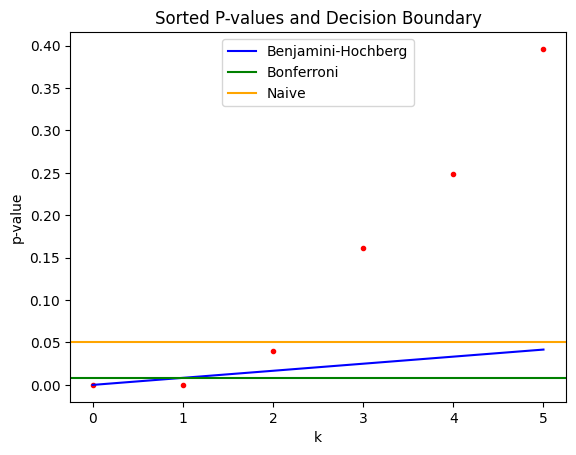

In [ ]:
# plot the pvals and correction thresholds
alpha = 0.05
k = np.arange(len(p_val_df))
m =  6

# Calculate y values based on the equation
y_values = k * alpha / m

# Plotting
plt.plot( k,y_values, color='b', label = 'Benjamini-Hochberg')
plt.axhline( alpha/m, color='g', label = 'Bonferroni')
plt.axhline( alpha, color='orange', label = 'Naive')
plt.scatter(p_val_df.index , np.sort(p_val_df['Value']) , marker='.', color = 'r')
plt.title('Sorted P-values and Decision Boundary')
plt.xlabel('k')
plt.ylabel('p-value')
plt.legend(loc='upper center')
plt.show()

# Causal Inference

<AxesSubplot: xlabel='Primary %', ylabel='Count'>

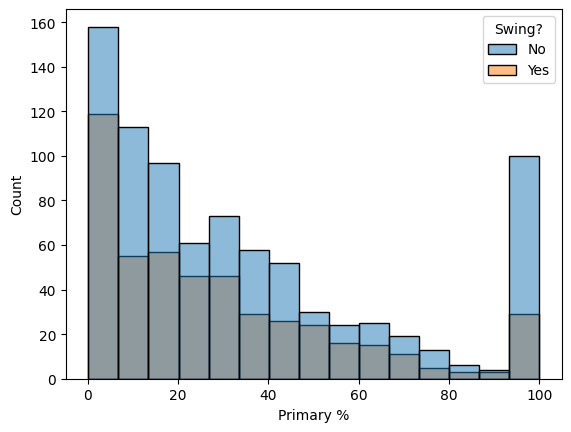

In [ ]:
#histogram of primary% split by if they are swing or not
sns.histplot(data = all_merged, x = 'Primary %', hue= 'Swing?')

One thing that we wanted to analyze was the potential influence being a swing state had on the primary %. This was important for us to analyze because it is important to see if this variable can have an effect and how much that effect really is. To do this, we created two histograms, one showing the distribution of primary % for swing states and one showing the distribution of primary % for non-swing states. From what we see, the difference between the two distributions is very minimal. They both skew right, having less and less height the more you go left. The similarities between the two distributions suggests that being a swing state or not doesn't really have that much effect on the primary %. 

The similarities in the distribution suggests that other factors than being a swing state may be more important in determining primary %. With this knowledge we can focs on exploring other factors that potentially might have more of an effect on primary %. This was still very helpful because it showed us that we don't need to focus on the swing state variable as an influencer and to focus on other variables that can drive the primary %.

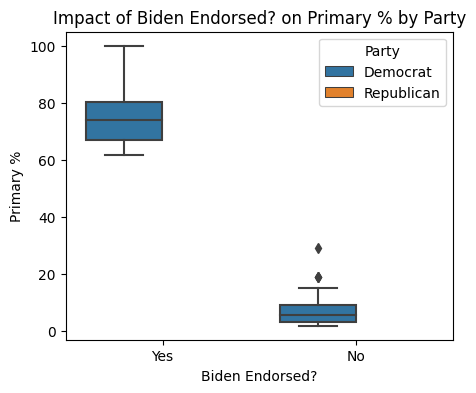

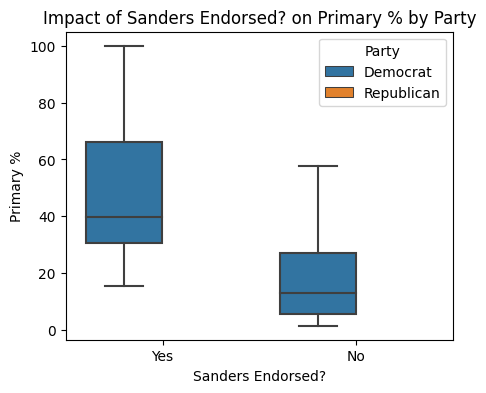

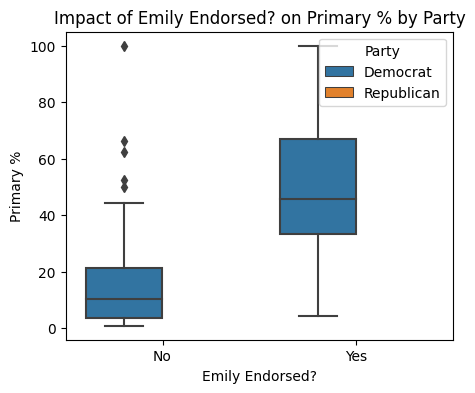

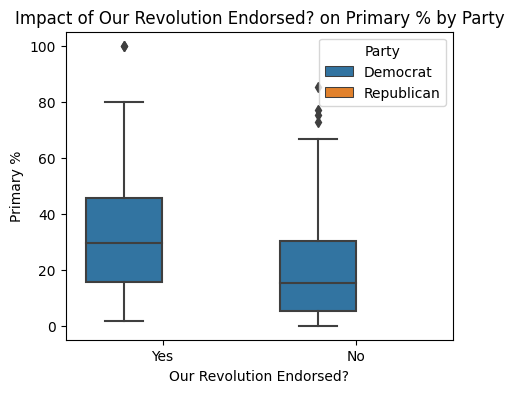

In [ ]:
#boxplot of endorsements
dem['Party'] = 'Democrat'
rep['Party'] = 'Republican'

# Combine datasets
all_candidates = pd.concat([dem, rep], ignore_index=True)
# List of endorsement columns
dem[['Emily Endorsed?','Biden Endorsed?',
                 'Sanders Endorsed?', 'Our Revolution Endorsed?']] = dem[['Emily Endorsed?', 'Biden Endorsed?', 
                                    'Sanders Endorsed?', 'Our Revolution Endorsed?']].fillna('No')
endorsement_cols = ['Biden Endorsed?', 'Sanders Endorsed?', 'Emily Endorsed?', 'Our Revolution Endorsed?']

# Plot impact of endorsements on Primary %
for col in endorsement_cols:
    plt.figure(figsize=(5,4))
    sns.boxplot(x=col, y='Primary %', hue='Party', data=all_candidates)
    plt.title(f'Impact of {col} on Primary % by Party')
    plt.xlabel(col)
    plt.ylabel('Primary %')
    plt.show()

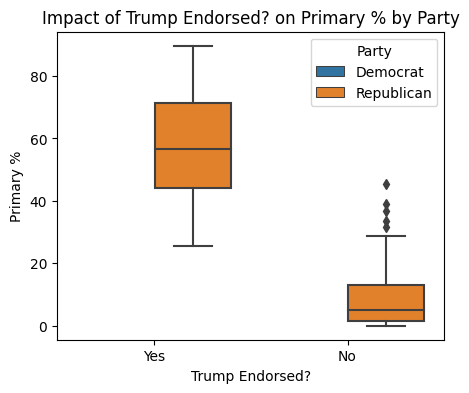

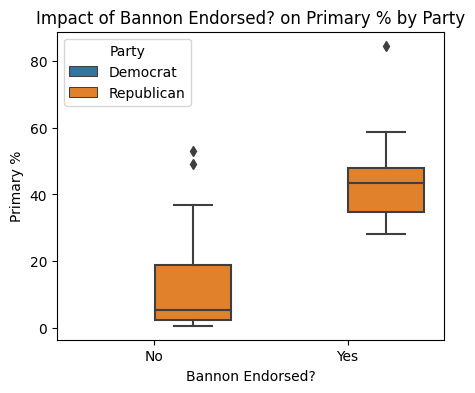

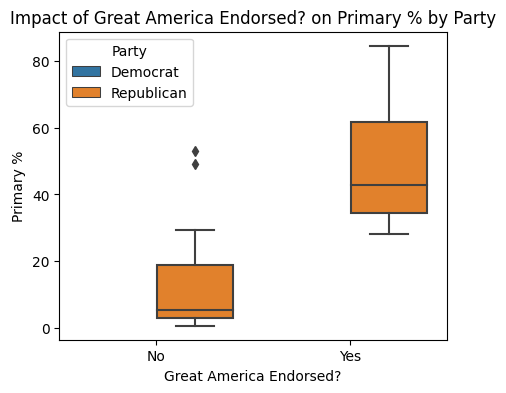

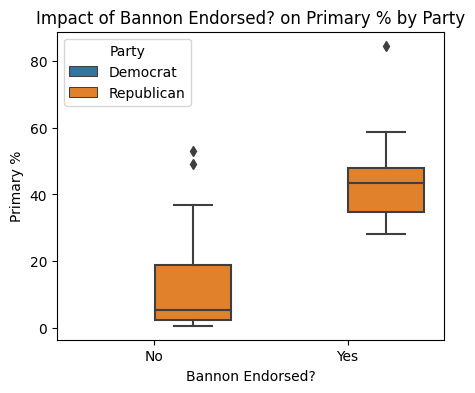

In [ ]:
# List of endorsement columns
endorsement_cols = ['Trump Endorsed?', 'Bannon Endorsed?', 'Great America Endorsed?', 'Bannon Endorsed?']
rep[['Trump Endorsed?', 'Bannon Endorsed?', 
'Great America Endorsed?', 'NRA Endorsed?']] = rep[['Trump Endorsed?', 'Bannon Endorsed?', 
'Great America Endorsed?', 'NRA Endorsed?']].fillna('No')

# Plot impact of endorsements on Primary %
for col in endorsement_cols:
    plt.figure(figsize=(5,4))
    sns.boxplot(x=col, y='Primary %', hue='Party', data=all_candidates)
    plt.title(f'Impact of {col} on Primary % by Party')
    plt.xlabel(col)
    plt.ylabel('Primary %')
    plt.show()

The box plots display relationships between endorsements and primary vote % earned, across a variety of endorsement types and across both the Democrat and Republican party. These plots provide us with a greater understanding of how endorsements from interest groups and prominent figures impact outcomes of primary elections across all candidates, separated by party. 

Candidates with endorsements outperform those without endorsements across the variety of politicians and interest groups that we analyzed here, yet the margin of impact differs across each endorsement. We see large divides from endorsements from big-name politicians, such as Trump and Biden, where there are very large differences in the primary % earned between endorsed and non-endorsed candidates. For other figures, such as Sanders and Bannon, as well as interest groups, the difference is not as pronounced, which may be influenced by the popularity of each figure and group, as well as by other important factors in each candidacy.

The analysis reveals a nuanced relationship between candidate endorsements and primary election outcomes, suggesting that the impact varies based on the endorsing entity. Further investigation, through causal inference techniques, would allow us to explore, in depth, the causal impact of endorsements on candidates' success in primary elections.

# Causal Inference (Cameron and Saaketh)

In [ ]:
#function for ols
def fit_OLS_model(df, target_variable, explanatory_variables, intercept = False):
    """
    Fits an OLS model from data.
    
    Inputs:
        df: pandas DataFrame
        target_variable: string, name of the target variable
        explanatory_variables: list of strings, names of the explanatory variables
        intercept: bool, if True add intercept term
    Outputs:
        fitted_model: model containing OLS regression results
    """
    
    target = df[target_variable]
    inputs = df[explanatory_variables]
    if intercept:
        inputs = sm.add_constant(inputs)
    
    fitted_model = sm.OLS(target, inputs).fit()
    return(fitted_model)

def mean_squared_error(true_vals, predicted_vals):
    """
    Return the mean squared error
    
    Inputs:
        true_vals: array of true labels
        predicted_vals: array labels predicted from the data
    Output:
        float, mean squared error of the predicted values
    """
    return np.mean((true_vals - predicted_vals) ** 2)

In [ ]:
#functions for bootstrapping ate
def draw_tau_hat(data, outcome, cons, random_state = None):
    """Returns a single bootstrapped estimate of the ATE.
    
    Inputs:
        data: DataFrame of observed data
        random_state: integer to help standardize sampling output 
        for grading and troubleshooting purposes
    Output:
        float, estimated average treatment effect
    """
    sample = data.sample(frac = 1, replace = True, random_state = random_state)
    fit_model = fit_OLS_model(sample, outcome, cons)
    estimated_ate = fit_model.params[0]
    return estimated_ate

def get_bootstrapped_ate(data, outcome, cons, n = 1000, random_state = None):
    """Returns n bootstrapped estimates of the ATE.
    
    Inputs:
        data: DataFrame of observed data
        n: number of bootstrapped estimates we would like to return
    Output:
        list of estimated average treatment effects
    """
    estimates = []
    for i in np.arange(n):
        estimates += [draw_tau_hat(data, outcome, cons, random_state)]
    return estimates

## Causal Inference with No Significant Imputation

In [ ]:
#unbiased confounders
unbiased_var = ['Cand_Party_Affiliation', 'Primary %', 'Net_Contribution', 'Net_Operating_Expenditure', 'Swing?'] 

In [ ]:
unbiased = all_merged.copy()[unbiased_var]
unbiased.head()

,Cand_Party_Affiliation,Primary %,Net_Contribution,Net_Operating_Expenditure,Swing?
0,REP,3.88,0.00,0.00,No
1,REP,23.30,121131.00,167307.75,No
2,REP,100.00,1860.00,3525.33,No
3,REP,44.81,51207.00,19564.00,Yes
4,REP,44.81,1770173.79,1961389.09,Yes


In [ ]:
# changing it to dummy
unbiased['is_dem'] = pd.get_dummies(unbiased['Cand_Party_Affiliation'], dtype = float).drop(columns = ['REP'])['DEM']
unbiased['swing'] = pd.get_dummies(unbiased['Swing?'], dtype = float)['Yes']
unbiased= unbiased.drop(columns = ['Cand_Party_Affiliation', 'Swing?'])
unbiased

,Primary %,Net_Contribution,Net_Operating_Expenditure,is_dem,swing
0,3.88,0.00,0.00,0.0,0.0
1,23.30,121131.00,167307.75,0.0,0.0
2,100.00,1860.00,3525.33,0.0,0.0
3,44.81,51207.00,19564.00,0.0,1.0
4,44.81,1770173.79,1961389.09,0.0,1.0
...,...,...,...,...,...
1325,38.43,5347252.57,5750487.11,1.0,1.0
1326,100.00,5728583.20,6270601.08,1.0,0.0
1327,100.00,1354858.98,1341508.97,1.0,0.0
1328,28.00,110167.66,110197.68,1.0,0.0


In [ ]:
# drop NA 
unbiased_clean = unbiased.copy().dropna()
unbiased_clean.head()

,Primary %,Net_Contribution,Net_Operating_Expenditure,is_dem,swing
0,3.88,0.00,0.00,0.0,0.0
1,23.30,121131.00,167307.75,0.0,0.0
2,100.00,1860.00,3525.33,0.0,0.0
3,44.81,51207.00,19564.00,0.0,1.0
4,44.81,1770173.79,1961389.09,0.0,1.0


In [ ]:
# randomizing 
unbiased_clean['is_dem'] = unbiased_clean['is_dem'].sample(frac=1, random_state=42).values
unbiased_clean['swing'] = unbiased_clean['swing'].sample(frac=1, random_state=42).values

In [ ]:
# running the outcome regression
linear_model1a = fit_OLS_model(df=unbiased_clean, target_variable='Primary %', explanatory_variables=['Net_Contribution', 'Net_Operating_Expenditure', 'is_dem', 'swing'])
print(linear_model1a.summary())

                                 OLS Regression Results                                
Dep. Variable:              Primary %   R-squared (uncentered):                   0.364
Model:                            OLS   Adj. R-squared (uncentered):              0.362
Method:                 Least Squares   F-statistic:                              187.8
Date:                Mon, 11 Dec 2023   Prob (F-statistic):                   2.54e-127
Time:                        21:37:41   Log-Likelihood:                         -6560.8
No. Observations:                1317   AIC:                                  1.313e+04
Df Residuals:                    1313   BIC:                                  1.315e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

In [ ]:
# sdo on unbiased 
sdo1 = unbiased_clean[unbiased_clean['is_dem'] == 1]['Primary %'].mean() - unbiased_clean[unbiased_clean['is_dem'] == 0]['Primary %'].mean() 
sdo1

-2.060765310060475

In [ ]:
# creating the confidence intervals
ates1 = get_bootstrapped_ate(unbiased_clean, 'Primary %', ['Net_Contribution', 'Net_Operating_Expenditure', 'is_dem', 'swing'], 1000)
confidence_interval1 = [np.percentile(ates1, 2.5), 
                       np.percentile(ates1, 97.5)]
print(f"Our 95% confidence interval ranges from {np.round(confidence_interval1[0], 6)} to {np.round(confidence_interval1[1], 6)}.")

Our 95% confidence interval ranges from -3e-06 to 8e-06.


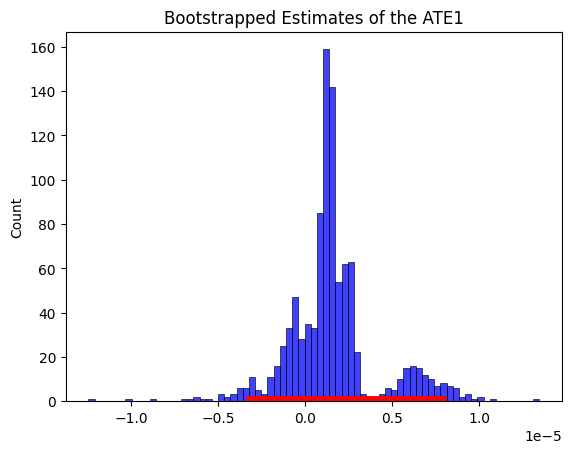

In [ ]:
#visualizing  the confidence intervals
sns.histplot(ates1, color = 'b')
plt.hlines(1, confidence_interval1[0], confidence_interval1[1], linewidth = 5, color = 'r')
plt.title('Bootstrapped Estimates of the ATE1');

## Causal Inference with All Confounders

In [ ]:
#every single confounder
biased_var = ['Cand_Party_Affiliation', 'Primary %', 'Net_Contribution', 'Net_Operating_Expenditure', 'Swing?', 'Race', 'Veteran?', 'LGBTQ?', 'STEM?', 'Obama Alum?'] 

In [ ]:
biased = all_merged.copy()[biased_var]
biased.head()

,Cand_Party_Affiliation,Primary %,Net_Contribution,Net_Operating_Expenditure,Swing?,Race,Veteran?,LGBTQ?,STEM?,Obama Alum?
0,REP,3.88,0.00,0.00,No,NaN,NaN,NaN,NaN,NaN
1,REP,23.30,121131.00,167307.75,No,NaN,NaN,NaN,NaN,NaN
2,REP,100.00,1860.00,3525.33,No,NaN,NaN,NaN,NaN,NaN
3,REP,44.81,51207.00,19564.00,Yes,NaN,NaN,NaN,NaN,NaN
4,REP,44.81,1770173.79,1961389.09,Yes,NaN,NaN,NaN,NaN,NaN


In [ ]:
#filling in the na values
biased['Race'] = biased['Race'].fillna('White')
biased['Veteran?'] = biased['Veteran?'].fillna('No')
biased['LGBTQ?'] = biased['LGBTQ?'].fillna('No')
biased['STEM?'] = biased['STEM?'].fillna('No')
biased['Obama Alum?'] = biased['Obama Alum?'].fillna('No')
biased.head()

,Cand_Party_Affiliation,Primary %,Net_Contribution,Net_Operating_Expenditure,Swing?,Race,Veteran?,LGBTQ?,STEM?,Obama Alum?
0,REP,3.88,0.00,0.00,No,White,No,No,No,No
1,REP,23.30,121131.00,167307.75,No,White,No,No,No,No
2,REP,100.00,1860.00,3525.33,No,White,No,No,No,No
3,REP,44.81,51207.00,19564.00,Yes,White,No,No,No,No
4,REP,44.81,1770173.79,1961389.09,Yes,White,No,No,No,No


In [ ]:
#creating the dummy values
biased['is_dem'] = pd.get_dummies(biased['Cand_Party_Affiliation'], dtype = float).drop(columns = ['REP'])['DEM']
biased['swing'] = pd.get_dummies(biased['Swing?'], dtype = float)['Yes']
biased['white'] = pd.get_dummies(biased['Race'], dtype = float).drop(columns = ['Nonwhite'])['White']
biased['veteran'] = pd.get_dummies(biased['Veteran?'], dtype = float)['Yes']
biased['lgbtq'] = pd.get_dummies(biased['LGBTQ?'], dtype = float)['Yes']
biased['stem'] = pd.get_dummies(biased['STEM?'], dtype = float)['Yes']
biased['obama'] = pd.get_dummies(biased['Obama Alum?'], dtype = float)['Yes']



biased = biased.copy().drop(columns = ['Cand_Party_Affiliation', 'Swing?', 'Race', 'Veteran?', 'LGBTQ?', 'STEM?', 'Obama Alum?'])
biased

,Primary %,Net_Contribution,Net_Operating_Expenditure,is_dem,swing,white,veteran,lgbtq,stem,obama
0,3.88,0.00,0.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,23.30,121131.00,167307.75,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,100.00,1860.00,3525.33,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,44.81,51207.00,19564.00,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,44.81,1770173.79,1961389.09,0.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1325,38.43,5347252.57,5750487.11,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1326,100.00,5728583.20,6270601.08,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1327,100.00,1354858.98,1341508.97,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1328,28.00,110167.66,110197.68,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
#dropping the na
biased_clean = biased.copy().dropna()
biased_clean.head()

,Primary %,Net_Contribution,Net_Operating_Expenditure,is_dem,swing,white,veteran,lgbtq,stem,obama
0,3.88,0.00,0.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,23.30,121131.00,167307.75,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,100.00,1860.00,3525.33,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,44.81,51207.00,19564.00,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,44.81,1770173.79,1961389.09,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
#randomizing
biased_clean['is_dem'] = biased_clean['is_dem'].sample(frac=1, random_state=42).values
biased_clean['swing'] = biased_clean['swing'].sample(frac=1, random_state=42).values
biased_clean['white'] = biased_clean['white'].sample(frac=1, random_state=42).values
biased_clean['veteran'] = biased_clean['veteran'].sample(frac=1, random_state=42).values
biased_clean['lgbtq'] = biased_clean['lgbtq'].sample(frac=1, random_state=42).values
biased_clean['stem'] = biased_clean['stem'].sample(frac=1, random_state=42).values
biased_clean['obama'] = biased_clean['obama'].sample(frac=1, random_state=42).values

In [ ]:
#outcome regression
linear_model1b = fit_OLS_model(df=biased_clean, target_variable='Primary %', explanatory_variables=['Net_Contribution', 'Net_Operating_Expenditure', 'is_dem','swing','white','veteran','lgbtq','stem','obama'])
print(linear_model1b.summary())

                                 OLS Regression Results                                
Dep. Variable:              Primary %   R-squared (uncentered):                   0.524
Model:                            OLS   Adj. R-squared (uncentered):              0.520
Method:                 Least Squares   F-statistic:                              159.8
Date:                Mon, 11 Dec 2023   Prob (F-statistic):                   1.54e-203
Time:                        21:37:44   Log-Likelihood:                         -6370.3
No. Observations:                1317   AIC:                                  1.276e+04
Df Residuals:                    1308   BIC:                                  1.281e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

In [ ]:
#sdo for all confounders regression
sdo2 = biased_clean[biased_clean['is_dem'] == 1]['Primary %'].mean() - biased_clean[biased_clean['is_dem'] == 0]['Primary %'].mean() 
sdo2

-2.060765310060475

In [ ]:
#creating the confidence interval
ates2 = get_bootstrapped_ate(biased_clean, 'Primary %', ['Net_Contribution', 'Net_Operating_Expenditure', 'is_dem','swing','white','veteran','lgbtq','stem','obama'], 1000)
confidence_interval2 = [np.percentile(ates2, 2.5), 
                       np.percentile(ates2, 97.5)]
print(f"Our 95% confidence interval ranges from {np.round(confidence_interval2[0], 6)} to {np.round(confidence_interval2[1], 6)}.")

Our 95% confidence interval ranges from -3e-06 to 6e-06.


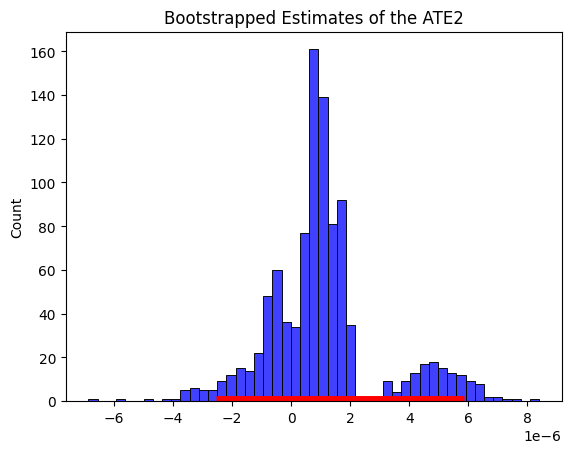

In [ ]:
#visualizing the confidence interval
sns.histplot(ates2, color = 'b')
plt.hlines(1, confidence_interval2[0], confidence_interval2[1], linewidth = 5, color = 'r')
plt.title('Bootstrapped Estimates of the ATE2');

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9ae92cc7-7a3d-460f-835b-1659a4f328f6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>